<a href="https://colab.research.google.com/gist/rajpurkar/5386c3096168c5343d8889308d62365b/stable-diffusion-finetuning-public-version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stable Diffusion fine-tuning**
Fine-tunes diffusers Stable Diffusion

### Setup

In [17]:
!nvidia-smi

Fri Oct 28 09:14:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.08    Driver Version: 510.73.08    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:1E.0 Off |                    0 |
| N/A   30C    P0    37W / 300W |   7273MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:
#@title Install dependencies
!pip install diffusers accelerate bitsandbytes torch-ema
!pip install transformers scipy ftfy "ipywidgets>=7,<8"
!pip install deepspeed triton mpi4py

You also need to accept the model license before downloading or using the weights. In this post we'll use model version `v1-4`, so you'll need to  visit [its card](https://huggingface.co/CompVis/stable-diffusion-v1-4), read the license and tick the checkbox if you agree. 

You have to be a registered user in 🤗 Hugging Face Hub, and you'll also need to use an access token for the code to work. For more information on access tokens, please refer to [this section of the documentation](https://huggingface.co/docs/hub/security-tokens).

In [19]:
from huggingface_hub import notebook_login
notebook_login()

In [20]:
#@title Model loading
import torch
from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4",
                                               # revision="fp16", torch_dtype=torch.float16,
                                               torch_dtype=torch.float32,  # bfloat16,
                                               use_auth_token=True)
pipe = pipe.to("cuda")
# pipe.scheduler.set_timesteps(1000)  # TODO
del pipe.safety_checker
pipe.safety_checker = lambda clip_input, images: (images, [False for _ in images])  # haha

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

In [21]:
# from google.colab import drive
# drive.mount('/content/drive')

### Load dataset

In [22]:
#@title Load dataset
#@markdown - Upload a zip file
#@markdown - file names are prompts
#@markdown - If you leave the dataset_link blank, colab will give you an upload button instead.
#@markdown - Alternatively you can provide a csv file with the prompt for each image in the desc_link or desc_filename section.
# import requests.exceptions
# dataset_link = ""  #@param {type: "string", allow-input: true} ["", "https://drive.google.com/uc?id=17bPt7G3N_vGKCCxppIOPbPlhv1qUnv0o", "https://drive.google.com/uc?id=1p4xwKEDHPhm18zBS_pMVJ1mp2Y5CE1a8"]
# desc_link = ""  #@param {type: "string", allow-input: true} ["", "https://drive.google.com/uc?id=1iSDbibP-o9gIk9YzpmI-Y_h_uWPqxTZh"]
# desc_filename = ""  #@param {type: "string", allow-input: true} ["", "desc.csv"]
# no_prompt = False  #@param {type: "boolean"}


# try:
#     import gdown
#     gdown.download(dataset_link)
# except requests.exceptions.MissingSchema:
#     from google.colab import files
#     print("Upload dataset:")
#     uploaded = list(files.upload())
#     if True:
#         path = uploaded[0]
#     else:
#         print("Please upload something. Erroring out soon...")
#     !mv {path} dataset.zip
# !unzip -q -o -d data dataset.zip
# from PIL import Image


# def check_image(path):
#     try:
#         Image.open(path)
#         return True
#     except:
#         return False

# import os
# import glob
# # import shutil
# imgs = [f for f in glob.glob("data/**", recursive=True) if os.path.isfile(f) and check_image(f)]
# stemns = {os.path.basename(img): img for img in imgs}
# # for k, v in stemns.items():
# #     k2 = k.replace("jpeg", "jpg").replace("JPG", "jpg")  # ???
# #     stemns[k2] = v

# try:
#     gdown.download(desc_link, "desc.csv")
# except requests.exceptions.MissingSchema:
#     pass
  

# if no_prompt:
#     titles = ["" for img in imgs]
# elif os.path.exists("desc.csv"):
#     import pandas as pd
#     captions = pd.read_csv("desc.csv")
#     imgs, titles = zip(*[
#         (stemns[name], caption)
#         for *_, name, caption in captions.itertuples()
#         if name in stemns])
# else:
#     from pathlib import Path
#     titles = [Path(img).stem for img in imgs]

In [23]:
import pandas as pd
df = pd.read_csv("joined.csv")
imgs = df['path']
titles = df['report']

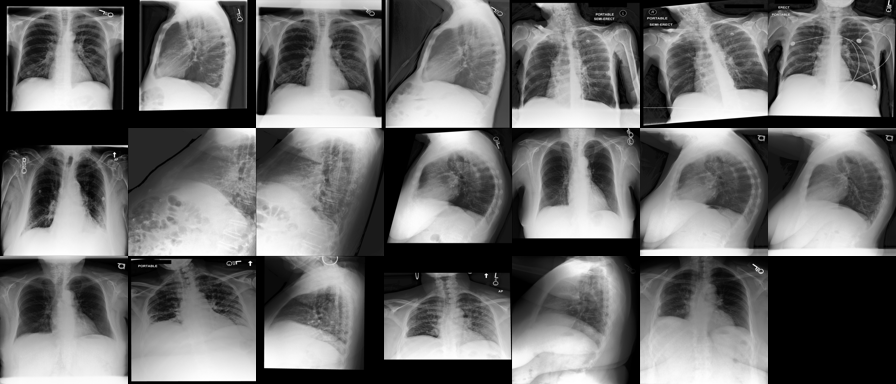

In [24]:
from torchvision import transforms as TF
from PIL import Image
import random

#@markdown This will resize, then display the first 20 images in your dataset.
class Text2ImageDataset(torch.utils.data.Dataset):
    def __init__(self, texts, images, resize=False, flip=False, cfg_prob=0.0):
        super().__init__()
        self.texts = texts
        self.images = images
        self.transform = TF.Compose([
            TF.Resize(512),
            TF.Resize((512, 512)) if resize else TF.CenterCrop(512),
        ] + ([TF.RandomHorizontalFlip()] if flip else []) + [
            TF.ToTensor(),
            TF.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        ])
        self.cfg_prob = cfg_prob
    
    def __len__(self):
        assert len(self.texts) == len(self.images)
        return len(self.texts)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        img = Image.open(img).convert("RGB")
        text = self.texts[idx] if random.random() > self.cfg_prob else ""
        return (self.texts[idx], self.transform(img))


flip = False #@param {type: "boolean"}
resize = True  #@param {type: "boolean"}
cfg_prob = 0.2  #@param {type: "number"}

dataset = Text2ImageDataset(titles, imgs, resize=resize, flip=flip,
                            cfg_prob=cfg_prob)

def show(x):
    return Image.fromarray(((x.permute(1, 2, 0).numpy() / 2 + 0.5) * 255).astype("uint8")).convert("RGB").resize((128, 128))


def image_grid(imgs, rows, cols):
    # assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


num_images = 20  #@param {type: "integer"}
cols = 7  #@param {type: "integer"}
pics = [show(i) for _, (t, i) in zip(range(num_images), dataset)]
image_grid(pics, (len(pics) - 1) // cols + 1, cols)

In [25]:
train_size = 0.8  #@param {type: "number"}
train_len = int(len(dataset) * train_size)
train_ds, test_ds = torch.utils.data.random_split(dataset, [train_len, len(dataset) - train_len])

### Train the model

In [26]:
#@title Create dataloader
# not today old friend
# from accelerate import Accelerator
# accelerator = Accelerator(gradient_accumulation_steps=grad_acc)
train_bs = 1  #@param {type: "integer"}
test_bs = 1  #@param {type: "integer"}
train_dl, test_dl = (torch.utils.data.DataLoader(train_ds, batch_size=train_bs, shuffle=True, num_workers=0),
                     torch.utils.data.DataLoader(test_ds, batch_size=test_bs, shuffle=True, num_workers=0))

In [54]:
#@title Prepare optimizer
from itertools import chain
from transformers import get_scheduler
from torch_ema import ExponentialMovingAverage


train_steps = 500  #@param {type: "integer"}
warmup = 48  #@param {type: "integer"}
grad_acc = 4  #@param {type: "integer"}

lr = 1e-3  #@param {type: "number"}
wd = 1e-5  #@param {type: "number"}
ema_decay = 0.0  #@param {type: "number"}
scheduler_type = "linear" #@param {type: "string"} ["cosine", "constant", "constant_with_warmup", "linear"]
pipe.text_encoder.requires_grad_(False)
pipe.unet.requires_grad_(False)
pipe.vae.requires_grad_(False)
#@markdown "Text" gives slightly better results. Equivalent to prompt tuning when
#@markdown `no_prompt` is checked.
# to_tune = "text"  #@param {type: "string"} ["text", "unet", "FULL"]
to_tune = "unet"  #@param {type: "string"} ["text", "unet", "FULL"]
model = (
    pipe.unet
        if to_tune == "unet"
    else torch.nn.ModuleList([pipe.unet, pipe.text_encoder])
        if to_tune == "full"
    else pipe.text_encoder
        if to_tune == "text"
    else 1/0)
# model = torch.nn.ModuleList([pipe.unet, pipe.text_encoder])
pipe.guidance_scale = 1.0 # Haha
# TODO
# "token_embedding" or "position_embedding"  # ?
condition = lambda x: (
    ("norm" in x or "bias" in x or "emb" in x or "attn" in x)
    if to_tune in ("unet", "full") else True)  # "token_embedding" in x  # "norm" in x or "bias" in x or "emb" in x  # or "transformer" in x  # True  # TODO
params = [y for x, y in model.named_parameters() if condition(x)]
for param in params:
    param.requires_grad_(True)
print("Tunable parameters:", sum([x.numel() for x in params]))
adam_kwargs = dict(lr=lr, weight_decay=wd, betas=(0.9, 0.99), eps=1e-8)
# import bitsandbytes as bnb
# optimizer = bnb.optim.Adam8bit(params, lr=lr, weight_decay=wd)
from argparse import Namespace
import deepspeed
_, optimizer, *_ = deepspeed.initialize(args=Namespace(**{}), model=model, model_parameters=params, config={
    "optimizer": {
        "type": "Adam",
        "params": adam_kwargs
    },
    "offload_optimizer": "cpu",
    "train_batch_size": train_bs
})
# optimizer = torch.optim.AdamW(params, **adam_kwargs)
# optimizer = torch.optim.SGD(params, lr=lr * 100, weight_decay=wd)
if ema_decay > 0:
    ema = ExponentialMovingAverage(params, decay=ema_decay)
else:
    from argparse import Namespace
    ema = Namespace(average_parameters=lambda: open("/tmp/dontusethisplease", "w"),
                    update=lambda: None)
scheduler = get_scheduler(scheduler_type, optimizer, warmup,
                          train_steps // grad_acc)
# scaler = torch.cuda.amp.GradScaler()
global_i = 0

Tunable parameters: 121808324
[2022-10-28 13:48:15,663] [INFO] [logging.py:68:log_dist] [Rank 0] DeepSpeed info: version=0.7.4, git-hash=unknown, git-branch=unknown
[2022-10-28 13:48:15,720] [INFO] [logging.py:68:log_dist] [Rank 0] DeepSpeed Flops Profiler Enabled: False
Installed CUDA version 11.6 does not match the version torch was compiled with 11.3 but since the APIs are compatible, accepting this combination
Using /home/ec2-user/.cache/torch_extensions/py38_cu113 as PyTorch extensions root...
No modifications detected for re-loaded extension module fused_adam, skipping build step...
Loading extension module fused_adam...
Time to load fused_adam op: 0.002705812454223633 seconds
[2022-10-28 13:48:15,868] [INFO] [logging.py:68:log_dist] [Rank 0] Using DeepSpeed Optimizer param name adam as basic optimizer
[2022-10-28 13:48:15,934] [INFO] [logging.py:68:log_dist] [Rank 0] DeepSpeed Basic Optimizer = FusedAdam
[2022-10-28 13:48:15,935] [INFO] [logging.py:68:log_dist] [Rank 0] DeepSpee

In [55]:
#@title Update scheduler
from diffusers import DDPMScheduler
ps = pipe.scheduler
train_scheduler = ps  # DDPMScheduler(1000, ps.beta_start, ps.beta_end, "scaled_linear")  # ps.beta_schedule)
# train_scheduler = DDPMScheduler(
    # beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000, tensor_format="pt")
ps.beta_start = 0.00085
ps.beta_end = 0.012
ps.beta_schedule = "scaled_linear"  # pipe.encode_images()
# ps.set_timesteps(1000)  # TODO

In [56]:
#@title Set seed
#@markdown 0 for random seed
from transformers import set_seed
import random
seed = 0  #@param {type: "integer"}

if seed == 0:
    seed = random.getrandbits(16)

print("Using seed:", seed)
set_seed(seed)

Using seed: 21497


In [39]:
!pip install tqdm

In [57]:
#@title Fine-tuning
from IPython.display import display, clear_output
from ipywidgets import Output
import shutil
import gc
from tqdm import trange, tqdm


def get_loss(x, y):
    assert len(x) == len(y)
    bs = len(x)
    t = torch.randint(0, len(ts), (bs,)).long()
    t = ts[t]
    toks = pipe.tokenizer(x, padding=True, truncation=True, max_length=77)
    device = "cuda"
    dtype = torch.FloatTensor
    if True:  # with torch.autocast("cuda"):
        with torch.inference_mode():
            latent_model_input = pipe.vae.encode(y.type(dtype).to(device)).latent_dist.sample().cpu() * 0.18215
            noise = torch.randn_like(latent_model_input)
            noised = train_scheduler.add_noise(latent_model_input, noise, t)
        torch.set_grad_enabled(any(x.requires_grad for x in pipe.text_encoder.parameters()))
        text_embeddings = pipe.text_encoder(torch.LongTensor(toks.input_ids).to(device),
                                                attention_mask=torch.tensor(toks.attention_mask).type(dtype).to(device))[0]
        torch.set_grad_enabled(True)
        eps = pipe.unet(noised.to(device), t.long().to(device), encoder_hidden_states=text_embeddings)["sample"]
        loss = torch.nn.functional.mse_loss(noise.to(device), eps, reduction="none").mean([1, 2, 3]).mean()  # )
    return loss


def get_sd():
    return {k: v for k, v in model.named_parameters() if v.requires_grad}


ts = torch.LongTensor(train_scheduler.timesteps)
losses = []
generate_every = 50  #@param {type: "integer"}
n_generate = 1  #@param {type: "integer"}
save_every = 200  #@param {type: "integer"}
save_verbose = False  #@param {type: "boolean"}
bar = tqdm(initial=global_i, total=train_steps)
try:
    while True:
        print("Training...")
        total_loss = 0.0
        for i, (x, y) in enumerate(train_dl):
            model.train()
            gc.collect()
            torch.cuda.empty_cache()
            loss = get_loss(x, y)
            losses.append(loss.item())
            total_loss += loss.item()
            bar.set_postfix(loss=total_loss/(i + 1))
            loss.backward()
            # scaler.scale(loss).backward()
            if i % grad_acc == grad_acc - 1:
                torch.nn.utils.clip_grad_norm_(params, 0.5)
                optimizer.step()
                # scaler.step(optimizer)
                # scaler.update()
                scheduler.step()
                ema.update()
                bar.update()
                optimizer.zero_grad()
                if global_i % save_every == save_every - 1:
                    os.makedirs("checkpoints/", exist_ok=True)
                    filename = f"checkpoints/{global_i:06}.ckpt"
                    if save_verbose:
                        torch.save(dict(
                            iter=global_i + 1,
                            model=get_sd(),
                            optimizer=optimizer.state_dict()), filename)
                    else:
                        with ema.average_parameters():
                            torch.save(dict(
                                iter=global_i + 1,
                                model=get_sd()), filename)
                    shutil.copy(filename, "checkpoints/last.ckpt")
                if global_i % generate_every == generate_every - 1:
                    print(f"Generating step {global_i + 1}...")
                    with torch.inference_mode(), torch.autocast("cuda"):
                        model.eval()
                        out = Output()
                        display(out)
                        with ema.average_parameters():
                            for i, (x, y) in zip(range(n_generate), test_dl):
                                with out:
                                    print("Prompt:", x[0])
                                    display(pipe(x[0])["sample"][0])
                global_i += 1
                if global_i >= train_steps:
                    break
        if global_i >= train_steps:
            break
except KeyboardInterrupt:
    pass

100%|██████████| 500/500 [4:23:11<00:00, 40.39s/it, loss=0.0895]


Training...


Training...


Training...


     |████████████████████████████████| 9.4 MB 13.1 MB/s eta 0:00:01
     |████████████████████████████████| 295 kB 69.6 MB/s eta 0:00:01
     |████████████████████████████████| 965 kB 78.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 71.4 MB/s eta 0:00:01


Matplotlib is building the font cache; this may take a moment.


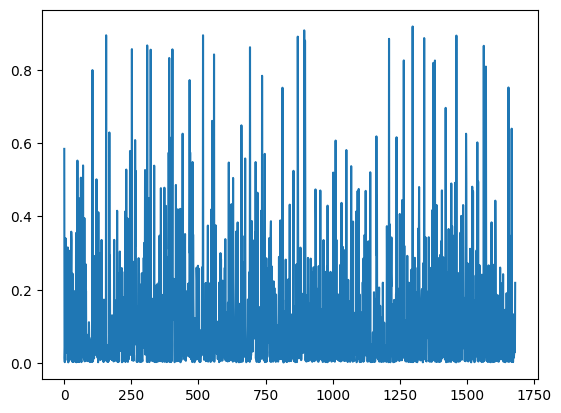

In [42]:
#@markdown Plot loss graph
# from inspect import getsource
# print(getsource(pipe.__call__))
!pip install matplotlib
from matplotlib import pyplot as plt
plt.plot(losses)
plt.show()

### Load checkpoint

In [43]:
import traceback


checkpoint_path = "checkpoints/last.ckpt"  #@param {type: "string", allow-input: true}  ["", "checkpoints/last.ckpt"]
try:
    dct = torch.load(checkpoint_path)
    global_i = dct["iter"]
    model.load_state_dict(dct["model"], strict=False)
    if "optimizer" in dct:
        optimizer.load_state_dict(dct["optimizer"])
except FileNotFoundError:
    pass
except:
    traceback.print_exc()

### Generate images from the fine-tuned model

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:54<00:00,  5.47s/it]


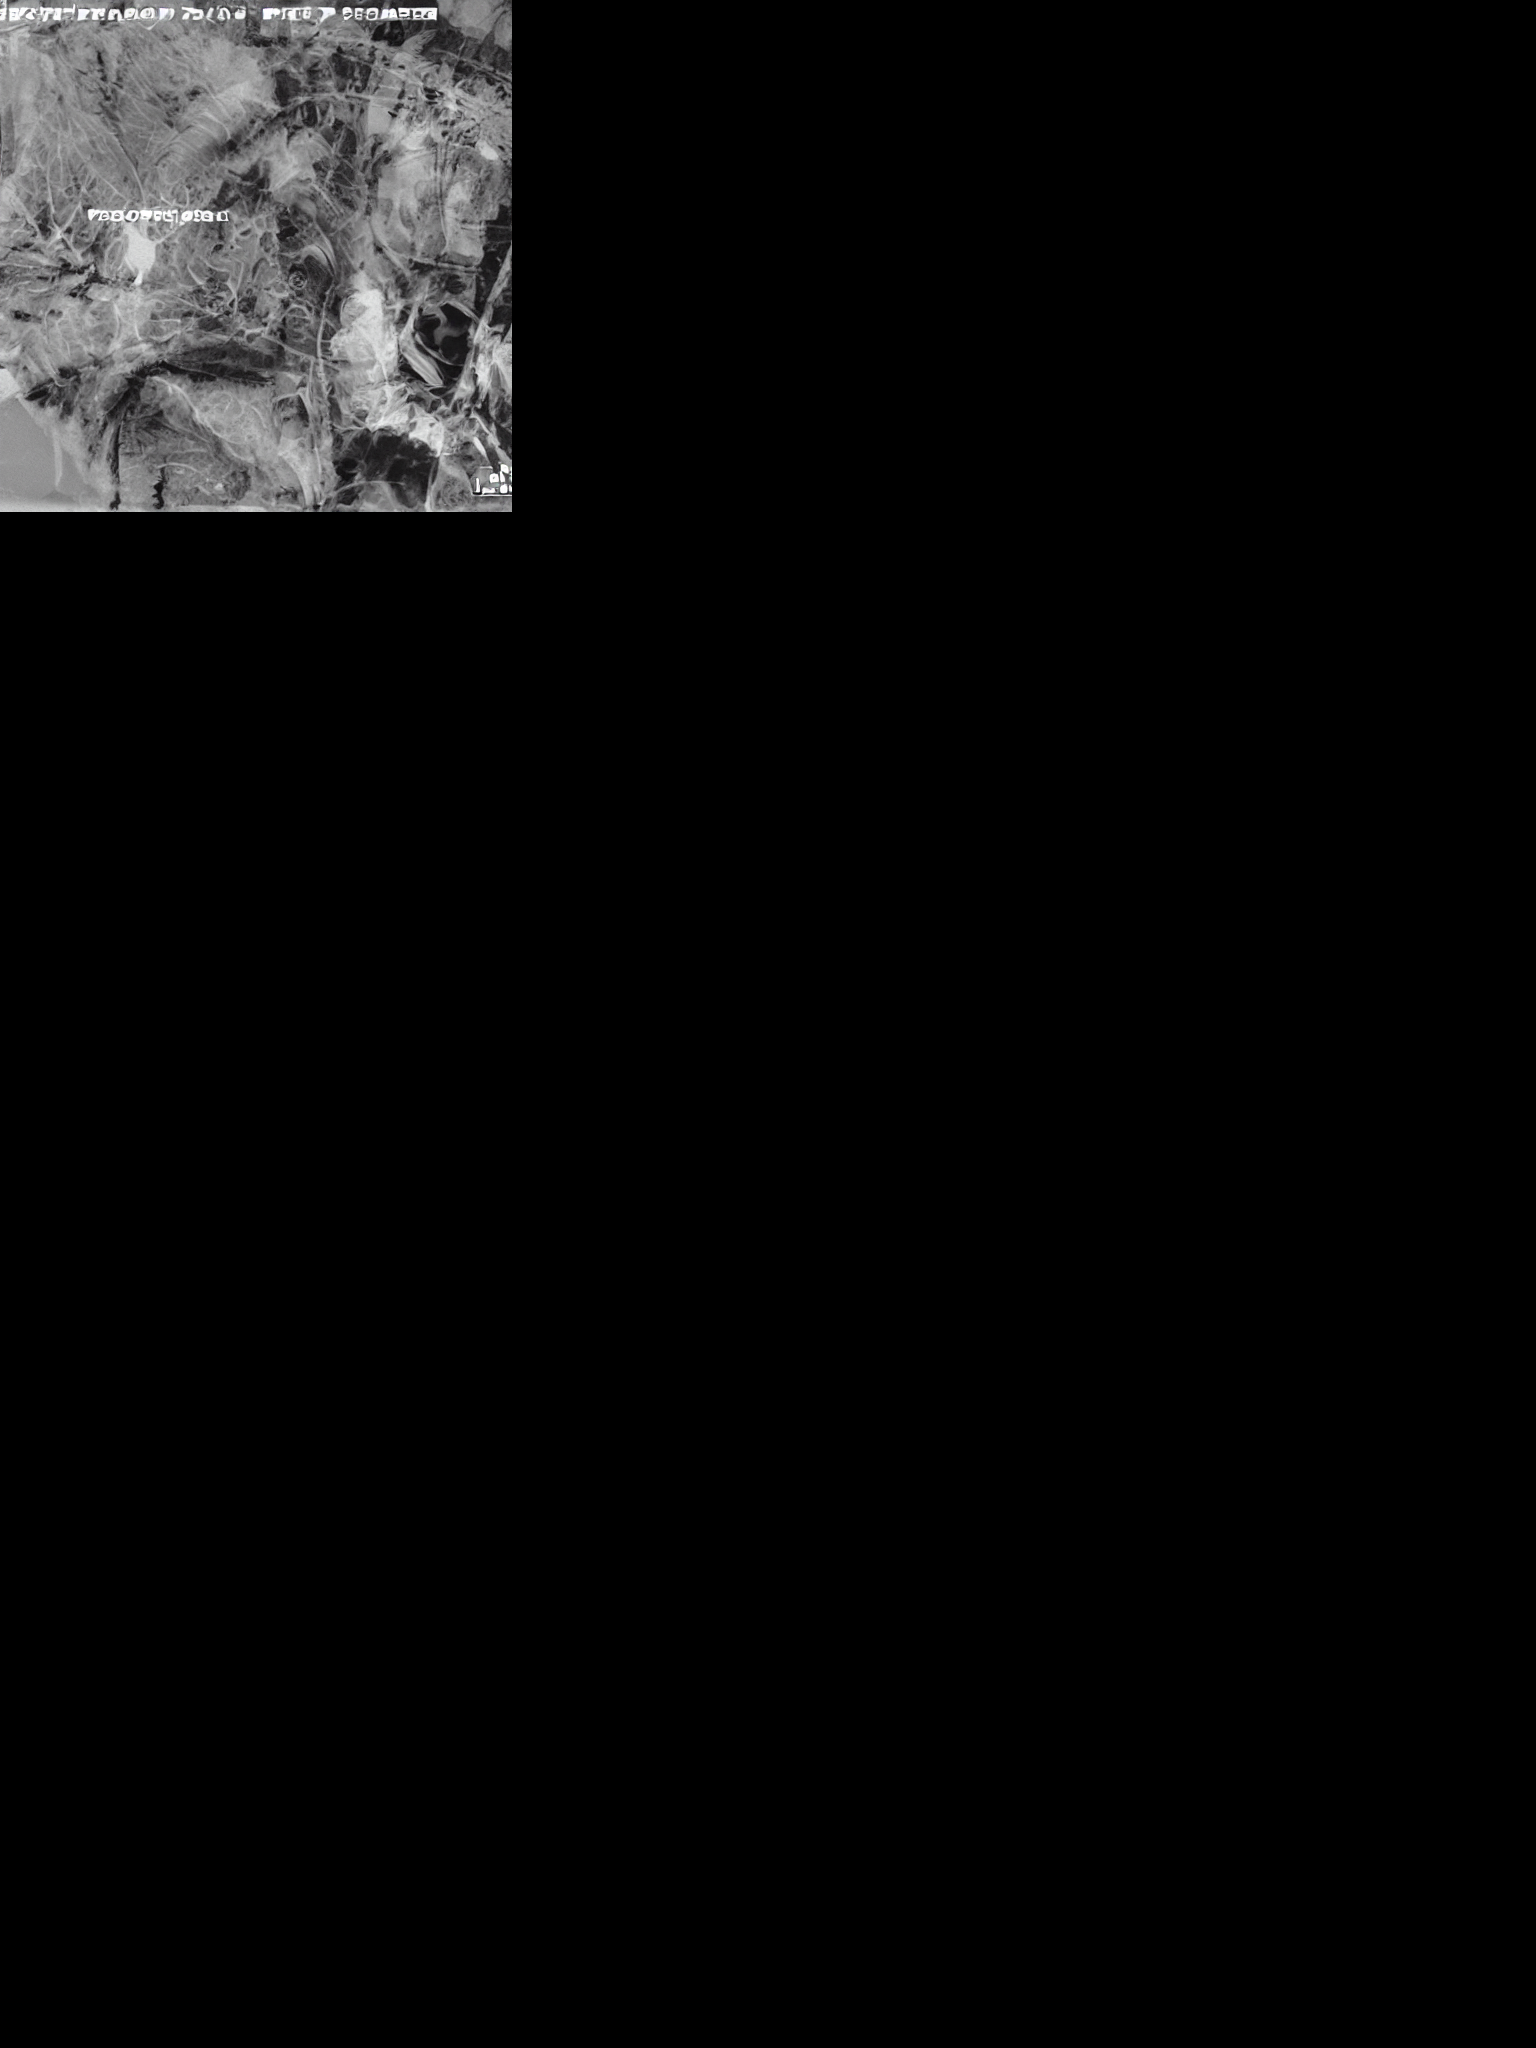

In [53]:
#!pip install more_itertools
from more_itertools import chunked


def image_grid(imgs, rows, cols):
    # assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


prompt = "No radiographic evidence for pneumonia."  #@param {type: "string"}
num_images = 10  #@param {type: "integer"}
cols = 3  #@param {type: "integer"}
use_ema = True  #@param {type: "boolean"}
bs = 1  # TODO
images = []
with torch.autocast("cuda"), torch.inference_mode(), (
    ema.average_parameters() if use_ema else open("/tmp/ihopethisfiledoesntactuallyexist", "w")):
    for i in tqdm(list(chunked([prompt] * num_images, bs))):
        images = pipe(i).images
image_grid(images, (num_images - 1) // cols + 1, cols)

### Save to Huggingface Hub

In [ ]:
#@title Save config
import json
config = {k: v for k, v in globals().items() if k in ["train_bs", "test_bs", "train_steps", "warmup", "grad_acc", "lr", "wd", "ema_decay", "scheduler_type", "to_tune"]}
json.dump(config, open("config.json", "w"))

In [ ]:
#@title Write model (empty name to skip)
#@markdown Requires a token with write access. Paste your model path from hugging face here. E.g. username/modelname
model_path = ""  #@param {type:"string"}

if True:
    from huggingface_hub import HfApi, HfFolder, create_repo
    from huggingface_hub.utils import HfHubHTTPError
    try:
        create_repo(model_path, private=True, repo_type="model")
    except HfHubHTTPError:
        pass
    api = HfApi()
    api.upload_file(
        path_or_fileobj="config.json",
        path_in_repo="conf.json",
        repo_id=model_path,
    )
    api.upload_file(
        path_or_fileobj="checkpoints/last.ckpt",
        path_in_repo="checkpoint.ckpt",
        repo_id=model_path,
    )